In [1]:
# Rebased here: https://github.com/jmduarte/pytorch_geometric/blob/add-trackml-to-dataset/torch_geometric/datasets/particle.py
from particle import TrackMLParticleTrackingDataset
import multiprocessing as mp
from tqdm.notebook import tqdm

In [2]:
# Download 100-event dataset
# Folllow instructions at https://github.com/Kaggle/kaggle-api to use API (download kaggle.json, etc.)
!if [ ! -d trackml_data ]; then kaggle competitions download -c trackml-particle-identification -f train_sample.zip -p trackml_data/raw/; unzip -j trackml_data/raw/train_sample.zip -d trackml_data/raw/; rm trackml_data/raw/train_sample.zip; fi

100%|████████████████████████████████████████▉| 861M/861M [00:09<00:00, 117MB/s]
100%|████████████████████████████████████████| 861M/861M [00:09<00:00, 90.4MB/s]
Archive:  trackml_data/raw/train_sample.zip
  inflating: trackml_data/raw/event000001054-particles.csv  
  inflating: trackml_data/raw/event000001092-cells.csv  
  inflating: trackml_data/raw/event000001072-particles.csv  
  inflating: trackml_data/raw/event000001062-particles.csv  
  inflating: trackml_data/raw/event000001093-hits.csv  
  inflating: trackml_data/raw/event000001052-truth.csv  
  inflating: trackml_data/raw/event000001013-cells.csv  
  inflating: trackml_data/raw/event000001049-hits.csv  
  inflating: trackml_data/raw/event000001038-cells.csv  
  inflating: trackml_data/raw/event000001002-cells.csv  
  inflating: trackml_data/raw/event000001056-truth.csv  
  inflating: trackml_data/raw/event000001082-cells.csv  
  inflating: trackml_data/raw/event000001043-hits.csv  
  inflating: trackml_data/raw/event000001095

  inflating: trackml_data/raw/event000001012-cells.csv  
  inflating: trackml_data/raw/event000001076-truth.csv  
  inflating: trackml_data/raw/event000001094-cells.csv  
  inflating: trackml_data/raw/event000001016-particles.csv  
  inflating: trackml_data/raw/event000001030-particles.csv  
  inflating: trackml_data/raw/event000001065-hits.csv  
  inflating: trackml_data/raw/event000001064-cells.csv  
  inflating: trackml_data/raw/event000001049-truth.csv  
  inflating: trackml_data/raw/event000001088-truth.csv  
  inflating: trackml_data/raw/event000001019-cells.csv  
  inflating: trackml_data/raw/event000001074-truth.csv  
  inflating: trackml_data/raw/event000001067-particles.csv  
  inflating: trackml_data/raw/event000001008-cells.csv  
  inflating: trackml_data/raw/event000001013-hits.csv  
  inflating: trackml_data/raw/event000001074-particles.csv  
  inflating: trackml_data/raw/event000001024-cells.csv  
  inflating: trackml_data/raw/event000001072-cells.csv  
  inflating: trac

  inflating: trackml_data/raw/event000001091-cells.csv  
  inflating: trackml_data/raw/event000001016-truth.csv  
  inflating: trackml_data/raw/event000001000-truth.csv  
  inflating: trackml_data/raw/event000001061-particles.csv  
  inflating: trackml_data/raw/event000001001-cells.csv  
  inflating: trackml_data/raw/event000001055-hits.csv  
  inflating: trackml_data/raw/event000001041-hits.csv  
  inflating: trackml_data/raw/event000001079-particles.csv  
  inflating: trackml_data/raw/event000001018-particles.csv  
  inflating: trackml_data/raw/event000001041-truth.csv  
  inflating: trackml_data/raw/event000001015-truth.csv  
  inflating: trackml_data/raw/event000001020-cells.csv  
  inflating: trackml_data/raw/event000001079-cells.csv  
  inflating: trackml_data/raw/event000001033-truth.csv  
  inflating: trackml_data/raw/event000001062-cells.csv  
  inflating: trackml_data/raw/event000001040-truth.csv  
  inflating: trackml_data/raw/event000001059-particles.csv  
  inflating: trac

In [3]:
# Construct dataset
data = TrackMLParticleTrackingDataset(root='trackml_data',transform=None, n_events=100,
                 directed=False, layer_pairs_plus=False,
                 volume_layer_ids=[[8, 2], [8, 4], [8, 6], [8, 8]], #Layers Selected
                 layer_pairs=[[7, 8], [8, 9], [9, 10]],             #Connected Layers
                 pt_min=2.0, eta_range=[-5, 5],                     #Node Cuts
                 phi_slope_max=0.0006, z0_max=150,                  #Edge Cuts
                 n_phi_sections=8, n_eta_sections=2,                #N Sections
                 augments=False, intersect=False, tracking=False,   #Toggle Switches
                 no_edge_features=True, 
                 n_workers=1, n_tasks=1)

Processing...
Constructing Graphs using n_workers = 1
Running task 0


  0%|          | 0/100 [00:00<?, ?it/s]/storage/user/jduarte/trackml_gnn_example/particle.py:311: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  nnz1 = mask1.nonzero().flatten()
100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


Done!


In [4]:
import torch
import torch_geometric
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Sigmoid
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer

node_feat = 3
edge_feat = 1
hidden = 8

class EdgeBlock(torch.nn.Module):
    def __init__(self):
        super(EdgeBlock, self).__init__()
        self.edge_mlp = Seq(Lin(node_feat*2+edge_feat, hidden), 
                            ReLU(),
                            Lin(hidden, hidden),
                            ReLU(),
                            Lin(hidden, hidden),
                            ReLU(),
                            Lin(hidden, edge_feat),
                            Sigmoid())

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest, edge_attr], 1)
        return self.edge_mlp(out)

class NodeBlock(torch.nn.Module):
    def __init__(self):
        super(NodeBlock, self).__init__()
        self.node_mlp = Seq(Lin(node_feat+edge_feat, hidden), 
                            ReLU(), 
                            Lin(hidden, hidden),
                            ReLU(),
                            Lin(hidden, node_feat),                        
                            )

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = scatter_mean(edge_attr, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        return self.node_mlp(out)


class InteractionNetwork(torch.nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()
        self.interactionnetwork = MetaLayer(EdgeBlock(), NodeBlock(), None)
        
    def forward(self, x, edge_index, edge_attr, batch):
        
        # 1st iteration 
        x, edge_attr, _ = self.interactionnetwork(x, edge_index, edge_attr, None, batch)
        # 2nd iteration (only care about output of EdgeBlock -> edge_attr)
        _, edge_attr, _ = self.interactionnetwork(x, edge_index, edge_attr, None, batch)
        
        return edge_attr
    
model = InteractionNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)

In [5]:
from torch_geometric.data import Data, DataListLoader, Batch


def collate(items):
    return Batch.from_data_list(items)

batch_size = 32

loader = DataListLoader(data, batch_size=batch_size, pin_memory=True, shuffle=True)
loader.collate_fn = collate


samples = len(data)

In [6]:
@torch.no_grad()
def test(model,loader,total,batch_size,leave=False):
    model.eval()
    
    xentropy = nn.BCELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader),total=total/batch_size,leave=leave)
    for i,data in t:
        data = data.to(device)
        batch_output = model(data.x, data.edge_index, data.edge_attr, data.batch).squeeze()
        batch_loss_item = xentropy(batch_output, data.y.type(torch.cuda.FloatTensor)).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size,leave=False):
    model.train()
    
    xentropy = nn.BCELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader),total=total/batch_size,leave=leave)
    for i,data in t:
        data = data.to(device)
        optimizer.zero_grad()
        batch_output = model(data.x, data.edge_index, data.edge_attr, data.batch).squeeze()
        batch_loss = xentropy(batch_output, data.y.type(torch.cuda.FloatTensor))
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [7]:
n_epochs = 100
stale_epochs = 0
best_valid_loss = 99999
patience = 5
t = tqdm(range(0, n_epochs))
import os.path as osp

for epoch in t:
    loss = train(model, optimizer, loader, samples, batch_size,leave=bool(epoch==n_epochs-1))
    valid_loss = test(model, loader, samples, batch_size,leave=bool(epoch==n_epochs-1))
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('           Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('interactionnetwork_best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 00, Training Loss:   0.6231
           Validation Loss: 0.6022
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   0.5404
           Validation Loss: 0.4811
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 02, Training Loss:   0.4805
           Validation Loss: 0.4474
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 03, Training Loss:   0.4392
           Validation Loss: 0.4404
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 04, Training Loss:   0.4307
           Validation Loss: 0.4076
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 05, Training Loss:   0.3940
           Validation Loss: 0.3625
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 06, Training Loss:   0.3811
           Validation Loss: 0.3735
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 07, Training Loss:   0.3504
           Validation Loss: 0.3447
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 08, Training Loss:   0.4464
           Validation Loss: 0.4207
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 09, Training Loss:   0.4020
           Validation Loss: 0.3765
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 10, Training Loss:   0.3714
           Validation Loss: 0.3619
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 11, Training Loss:   0.3504
           Validation Loss: 0.3326
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 12, Training Loss:   0.3252
           Validation Loss: 0.3133
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 13, Training Loss:   0.3193
           Validation Loss: 0.3139
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 14, Training Loss:   0.3248
           Validation Loss: 0.3349
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 15, Training Loss:   0.3161
           Validation Loss: 0.3113
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 16, Training Loss:   0.3103
           Validation Loss: 0.3048
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 17, Training Loss:   0.3083
           Validation Loss: 0.3069
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 18, Training Loss:   0.3093
           Validation Loss: 0.3001
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 19, Training Loss:   0.3050
           Validation Loss: 0.3014
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 20, Training Loss:   0.2984
           Validation Loss: 0.3351
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 21, Training Loss:   0.3151
           Validation Loss: 0.3019
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 22, Training Loss:   0.3051
           Validation Loss: 0.2995
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 23, Training Loss:   0.2945
           Validation Loss: 0.2865
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 24, Training Loss:   0.3017
           Validation Loss: 0.2999
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 25, Training Loss:   0.3033
           Validation Loss: 0.2975
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 26, Training Loss:   0.3000
           Validation Loss: 0.3017
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 27, Training Loss:   0.3027
           Validation Loss: 0.2959
Stale epoch


  0%|          | 0/50.0 [00:00<?, ?it/s]

  0%|          | 0/50.0 [00:00<?, ?it/s]

Epoch: 28, Training Loss:   0.2964
           Validation Loss: 0.2949
Stale epoch
Early stopping after 5 stale epochs


In [10]:
import numpy as np
t = tqdm(enumerate(loader),total=samples/batch_size)
y_test = []
y_predict = []
for i,data in t:
    data = data.to(device)    
    batch_output = model(data.x, data.edge_index, data.edge_attr, data.batch)    
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(data.y.cpu().numpy())
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

  0%|          | 0/50.0 [00:00<?, ?it/s]

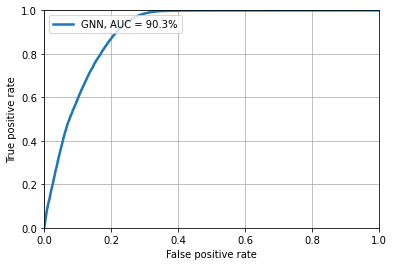

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_predict)
    
# plot ROC curves
plt.figure()
plt.plot(fpr_gnn, tpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.xlabel(r'False positive rate')
plt.ylabel(r'True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()